In [123]:
%matplotlib inline

%load_ext autoreload
%autoreload 2
from notebooks.imports import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
from src.utils import pmf_utils

### Load Configs

In [125]:
from config import dir_config, main_config

raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)

psych_model_type = 'logit_4'

## Load Data

In [126]:
aggregate_data = pd.read_csv(Path(raw_dir, "aggregate_data.csv"), index_col=None)
session_metadata = pd.read_csv(Path(raw_dir, "session_metadata.csv"), index_col=None)
session_metadata.head()

,subject_id,treatment,off_med_first,is_tremor_dominant,MoCA,sMMSE,BDI,BAI,UPDRS,210_Tremor,301_Speech,302_Facial_Expression,303a_Rigidity_Neck,303b_Rigidity_RUE,303c_Rigidity_LUE,303d_Rigidity_RLE,303e_Rigidity_LLE,304a_Finger_Tapping_RUE,304b_Finger_Tapping_LUE,305a_Hand_Movements_RUE,305b_Hand_Movements_LUE,306a_Pronation_Supination_Movements_RUE,306b_Pronation_Supination_Movements_LUE,307a_Toe_Tapping_RLE,307b_Toe_Tapping_LLE,308a_Leg_Agility_RLE,308b_Leg_Agility_LLE,309_Arising_from_Chair,310_Gait,311_Freezing_of_Gait,312_Postural_Stability,313_Posture,314_Global_Spontaneity_of_Movement,315a_Postural_Tremor_RUE,315b_Postural_Tremor_LUE,316a_Kinetic_Tremor_RUE,316b_Kinetic_Tremor_LUE,317a_Rest_Tremor_Amplitude_RUE,317b_Rest_Tremor_Amplitude_LUE,317c_Rest_Tremor_Amplitude_RLE,317d_Rest_Tremor_Amplitude_LLE,317e_Rest_Tremor_Amplitude_Lip_Jaw,318_Constancy_of_Rest_Tremor,Were_Diskinesias_Present,Did_these_Movements_Interfere_with_Ratings,Hoehn_and_Yahr_Stage,notes
0,P1,OFF,1.0,NaN,NaN,NaN,NaN,NaN,18.0,1.0,0.0,1.0,1.0,0.0,2.0,NaN,NaN,1.0,2.0,1.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no,no,2.0,NaN
1,P1,ON,1.0,NaN,NaN,NaN,NaN,NaN,16.0,NaN,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no,no,2.0,NaN
2,P3,OFF,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,no,no,NaN,NaN
3,P3,ON,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no,no,2.0,NaN
4,P4,OFF,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,2.0,NaN,NaN,2.0,NaN


#### Fill out the subject_metadata prior based on aggregate_data

In [127]:
for subject_id, medication in sorted(list(zip(session_metadata['subject_id'], session_metadata['treatment'])), key = lambda x: x[0]):
    # find the corresponding row in the aggregate data
    session_data = aggregate_data[(aggregate_data['subject_id'] == subject_id) & (aggregate_data['medication'] == medication.lower())]
    prior = np.unique(session_data['prior'])
    prior = prior[prior != 'eq']

    # in session_metadata, where subject and medication matches, update the prior
    current_idx = session_metadata[(session_metadata['subject_id'] == subject_id) & (session_metadata['treatment'] == medication)].index
    session_metadata.loc[current_idx, 'prior_condition'] = prior[0]
    session_metadata.loc[current_idx, 'file_name'] = np.unique(session_data['session_filename'])[0]

In [128]:
ucla = ["CG", "COH", "MBY", "DP", "FUR", "LBR", "MAR", "SMI", "PAM", "RW", "BBK", "BER", "DCAM", "ALE", "DMO", "AJL", "SKU"]
case_western = ["RBA", "RDE", "SGA", "LHO", "RSH", "RZA", "SNO"]
stanford = session_metadata.loc[
            session_metadata['subject_id'].str.match(r'^P\d+$', na=False) &  # Ensure it starts with 'P' followed by numbers
            (session_metadata['subject_id'].str.extract(r'P(\d+)')[0].astype(float) <= 24),  # Extract number and compare
            "subject_id"].unique()
harvard = session_metadata.loc[
            session_metadata['subject_id'].str.match(r'^P\d+$', na=False) &  # Ensure it starts with 'P' followed by numbers
            (session_metadata['subject_id'].str.extract(r'P(\d+)')[0].astype(float) > 24),  # Extract number and compare
            "subject_id"].unique()

# go through the session_metadata and update the site
for subject_id in session_metadata['subject_id']:
    if subject_id in ucla:
        site = "UCLA"
    elif subject_id in case_western:
        site = "Case_Western"
    elif subject_id in stanford:
        site = "Stanford"
    elif subject_id in harvard:
        site = "Harvard"
    else:
        site = "Unknown"
    session_metadata.loc[session_metadata['subject_id'] == subject_id, "experiment_site"] = site


In [129]:
print(session_metadata.isnull().sum())

# replace null with NaN
session_metadata.replace('', np.nan, inplace=True)
session_metadata.replace('NA', np.nan, inplace=True)

subject_id                                     0
treatment                                      0
off_med_first                                 14
is_tremor_dominant                            46
MoCA                                          86
sMMSE                                         52
BDI                                           53
BAI                                           52
UPDRS                                         20
210_Tremor                                    70
301_Speech                                    48
302_Facial_Expression                         48
303a_Rigidity_Neck                            48
303b_Rigidity_RUE                             48
303c_Rigidity_LUE                             48
303d_Rigidity_RLE                             51
303e_Rigidity_LLE                             51
304a_Finger_Tapping_RUE                       48
304b_Finger_Tapping_LUE                       48
305a_Hand_Movements_RUE                       48
305b_Hand_Movements_

In [130]:
print("------------- info ----------------")
print(session_metadata.info())
print("\n\n------------- head ----------------\n\n")
print(session_metadata.head())
print("\n\n------------- describe ----------------\n\n")
print(session_metadata.describe())
print("\n\n------------- dtypes ----------------\n\n")
print(session_metadata.dtypes)
print("\n\n------------- shape ----------------\n\n")
print(session_metadata.shape)

------------- info ----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 50 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   subject_id                                  86 non-null     object 
 1   treatment                                   86 non-null     object 
 2   off_med_first                               72 non-null     float64
 3   is_tremor_dominant                          40 non-null     float64
 4   MoCA                                        0 non-null      float64
 5   sMMSE                                       34 non-null     float64
 6   BDI                                         33 non-null     float64
 7   BAI                                         34 non-null     float64
 8   UPDRS                                       66 non-null     float64
 9   210_Tremor                                  16 non-nu

##### Data rejection

In [131]:
valid_data = aggregate_data[aggregate_data['is_valid'] == 1]
# chose trials with minimum reaction time from main_config
valid_data = valid_data[valid_data['reaction_time'] >= main_config.BEHAVIOR.min_rt]

#### Direction and color conversion to prior condition

In [132]:
# Ensure valid_data is a DataFrame you intend to modify directly
def data_preprocessing(data):

    # remove data from subjects listed in main_config.manual_rejection
    data = data[~data['subject_id'].isin(main_config.moca_rejection)]
    # remove equal prior sessions
    data = data[data['prior'] != 'eq']
    data['prior_color'].loc[data['prior'] == 'eq'] = np.NaN
    data['prior_direction'].loc[data['prior'] == 'eq'] = np.NaN

    left_prior_idx = data['prior_direction'] == 'left'
    right_prior_idx = data['prior_direction'] == 'right'
    green_prior_idx = data['prior_color'] == 'green'
    red_prior_idx = data['prior_color'] == 'red'

    # Renaming directions based on prior direction
    data.loc[left_prior_idx, 'target'] = data.loc[left_prior_idx, 'target'].map({'left': 1, 'right': 0})
    data.loc[left_prior_idx, 'choice'] = data.loc[left_prior_idx, 'choice'].map({'left': 1, 'right': 0})
    data.loc[right_prior_idx, 'target'] = data.loc[right_prior_idx, 'target'].map({'left': 0, 'right': 1})
    data.loc[right_prior_idx, 'choice'] = data.loc[right_prior_idx, 'choice'].map({'left': 0, 'right': 1})

    # Renaming colors based on prior color
    data.loc[green_prior_idx, 'color'] = data.loc[green_prior_idx, 'color'].map({'green': 1, 'red': 0})
    data.loc[red_prior_idx, 'color'] = data.loc[red_prior_idx, 'color'].map({'green': 0, 'red': 1})

    data['signed_coherence'] = data['coherence'] * (2 * data['target'] - 1)

    return data

valid_data = data_preprocessing(valid_data)
aggregate_data = data_preprocessing(aggregate_data)

#### Data Splicing

In [133]:
slicing = main_config.BEHAVIOR.data_slice

temp_valid_data = pd.DataFrame()
temp_aggregate_data = pd.DataFrame()

if slicing != 0:
	for subject_id, medication in sorted(list(zip(session_metadata['subject_id'], session_metadata['treatment'])), key = lambda x: x[0]):
		# find the corresponding row in the aggregate data
		session_agg_data = aggregate_data[(aggregate_data['subject_id'] == subject_id) & (aggregate_data['medication'] == medication.lower())]
		session_valid_data = valid_data[(valid_data['subject_id'] == subject_id) & (valid_data['medication'] == medication.lower())]

		if session_agg_data.empty or session_valid_data.empty:
			continue

		half = len(session_agg_data) // 2

		if slicing == 1:
			# Take first half
			agg_slice = session_agg_data.iloc[:half]
			valid_slice = session_valid_data.iloc[:half]
		elif slicing == 2:
			# Take second half
			agg_slice = session_agg_data.iloc[half:]
			valid_slice = session_valid_data.iloc[half:]
		else:
			# Use full session if slicing value is unexpected
			agg_slice = session_agg_data
			valid_slice = session_valid_data

		# Concatenate results
		temp_aggregate_data = pd.concat([temp_aggregate_data, agg_slice], ignore_index=True)
		temp_valid_data = pd.concat([temp_valid_data, valid_slice], ignore_index=True)

	aggregate_data = temp_aggregate_data
	valid_data = temp_valid_data

#### Rejecting sessions based on allowed lapse rates

In [134]:
sessions = valid_data['session_filename'].unique()

reject_sessions = []

for session in sessions:
	session_data = valid_data[valid_data['session_filename'] == session]
	accuracy_100prct = np.mean(session_data['outcome'][np.abs(session_data['coherence']) == 100]) * 100
	if accuracy_100prct < main_config.BEHAVIOR.min_easy_accuracy * 100:
		reject_sessions.append(session)
		print(f"Subject: {session} rejected due to low accuracy {accuracy_100prct:.2f}, with session size {len(session_data)}")
		continue

aggregate_data = aggregate_data[~aggregate_data['session_filename'].isin(reject_sessions)]
valid_data = valid_data[~valid_data['session_filename'].isin(reject_sessions)]


Subject: P27_OFFmeds_rl.mat rejected due to low accuracy 33.12, with session size 621
Subject: RZA_OFFmeds_gl.mat rejected due to low accuracy 59.21, with session size 599
Subject: P26_ONmeds_gr.mat rejected due to low accuracy 53.90, with session size 626
Subject: RSH_ONmeds_gl.mat rejected due to low accuracy 53.19, with session size 556
Subject: SKU_OFFmeds_rr.mat rejected due to low accuracy 54.11, with session size 592
Subject: SNO_ONmeds_rr.mat rejected due to low accuracy 54.78, with session size 640
Subject: P27_ONmeds_gl.mat rejected due to low accuracy 56.05, with session size 623
Subject: RZA_ONmeds_rl.mat rejected due to low accuracy 58.46, with session size 514
Subject: AJL_OFFmeds_gr.mat rejected due to low accuracy 52.63, with session size 610
Subject: P25_ONmeds_rr.mat rejected due to low accuracy 54.55, with session size 242
Subject: P26_OFFmeds_gl.mat rejected due to low accuracy 49.02, with session size 605
Subject: SNO_OFFmeds_gl.mat rejected due to low accuracy 59.

In [135]:
# finding subjects who have both on and off medication sessions
subject_sessions = valid_data.groupby('subject_id')['medication'].unique()

valid_subjects = []
for subject, sessions in subject_sessions.items():
    if len(sessions) == 2:
        valid_subjects.append(subject)

aggregate_data = aggregate_data[aggregate_data['subject_id'].isin(valid_subjects)]
valid_data = valid_data[valid_data['subject_id'].isin(valid_subjects)]
valid_session_metadata = session_metadata[session_metadata['subject_id'].isin(valid_subjects)]

print(f"Number of valid subjects: {len(valid_subjects)}")
print(valid_subjects)
print(f"Number of subjects: {len(valid_data['subject_id'].unique())}")
print(valid_data['subject_id'].unique())
print(f"Number of sessions: {len(valid_session_metadata['subject_id'].unique())}")
print(valid_session_metadata['subject_id'].unique())


Number of valid subjects: 35
['ALE', 'BBK', 'BER', 'CG', 'COH', 'DCAM', 'DMO', 'DP', 'FUR', 'LBR', 'LHO', 'MAR', 'MBY', 'P1', 'P11', 'P12', 'P13', 'P17', 'P18', 'P19', 'P20', 'P22', 'P23', 'P24', 'P3', 'P4', 'P6', 'P7', 'P9', 'PAM', 'RBA', 'RDE', 'RW', 'SGA', 'SMI']
Number of subjects: 35
['PAM' 'ALE' 'DMO' 'P11' 'COH' 'P20' 'CG' 'BER' 'P23' 'P6' 'MAR' 'RBA'
 'LBR' 'P12' 'LHO' 'SGA' 'P4' 'RDE' 'RW' 'P17' 'DP' 'SMI' 'P13' 'DCAM'
 'P7' 'P22' 'P9' 'FUR' 'P18' 'P1' 'P3' 'P24' 'P19' 'BBK' 'MBY']
Number of sessions: 35
['P1' 'P3' 'P4' 'P6' 'P7' 'P9' 'P11' 'P12' 'P13' 'P17' 'P18' 'P19' 'P20'
 'P22' 'P23' 'P24' 'CG' 'COH' 'MBY' 'DP' 'FUR' 'LBR' 'MAR' 'SMI' 'PAM'
 'RW' 'BBK' 'BER' 'DCAM' 'ALE' 'DMO' 'RBA' 'RDE' 'SGA' 'LHO']


In [136]:
# adding session_id to each subject off and on medication sessions

subject_sessions = valid_data.groupby('subject_id')['medication'].unique()

session_metadata['positive_bias'] = np.NaN
session_metadata['positive_bias'] = np.NaN
session_metadata['positive_psych_alpha'] = np.NaN
session_metadata['positive_psych_beta'] = np.NaN
session_metadata['positive_psych_lapse'] = np.NaN
session_metadata['positive_psych_guess'] = np.NaN

session_metadata['equal_psych_bias'] = np.NaN
session_metadata['equal_psych_bias'] = np.NaN
session_metadata['equal_psych_alpha'] = np.NaN
session_metadata['equal_psych_beta'] = np.NaN
session_metadata['equal_psych_lapse'] = np.NaN
session_metadata['equal_psych_guess'] = np.NaN

for subject, sessions in subject_sessions.items():
    for session in sessions:
        session_data = valid_data[(valid_data['subject_id'] == subject) & (valid_data['medication'] == session)]

        current_idx = session_metadata[(session_metadata['subject_id'] == subject) & (session_metadata['treatment'] == session.upper())].index

        positive_bias, positive_psych_bias, positive_psych_alpha, positive_psych_beta, positive_psych_lapse, positive_psych_guess = np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN
        equal_bias, equal_psych_bias, equal_psych_alpha, equal_psych_beta, equal_psych_lapse, equal_psych_guess = np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN

        coh, positive_psych, positive_model, _, _, = pmf_utils.get_psychometric_data(data=session_data[session_data['color'] == 1], model_type=psych_model_type)
        coh, equal_psych, equal_model, _, _, = pmf_utils.get_psychometric_data(data=session_data[session_data['color'] == 0], model_type=psych_model_type)

        session_metadata.loc[current_idx, 'positive_bias'] = positive_psych[3]
        session_metadata.loc[current_idx, 'positive_psych_bias'] = positive_model.predict(0)
        session_metadata.loc[current_idx, 'positive_psych_alpha'] = positive_model.coefs_['mean']
        session_metadata.loc[current_idx, 'positive_psych_beta'] = positive_model.coefs_['var']
        session_metadata.loc[current_idx, 'positive_psych_lapse'] = positive_model.coefs_['lapse_rate']
        session_metadata.loc[current_idx, 'positive_psych_guess'] = positive_model.coefs_['guess_rate']

        session_metadata.loc[current_idx, 'equal_bias'] = equal_psych[3]
        session_metadata.loc[current_idx, 'equal_psych_bias'] = equal_model.predict(0)
        session_metadata.loc[current_idx, 'equal_psych_alpha'] = equal_model.coefs_['mean']
        session_metadata.loc[current_idx, 'equal_psych_beta'] = equal_model.coefs_['var']
        session_metadata.loc[current_idx, 'equal_psych_lapse'] = equal_model.coefs_['lapse_rate']
        session_metadata.loc[current_idx, 'equal_psych_guess'] = equal_model.coefs_['guess_rate']


### Input decision-behavior parameters into session_metadata

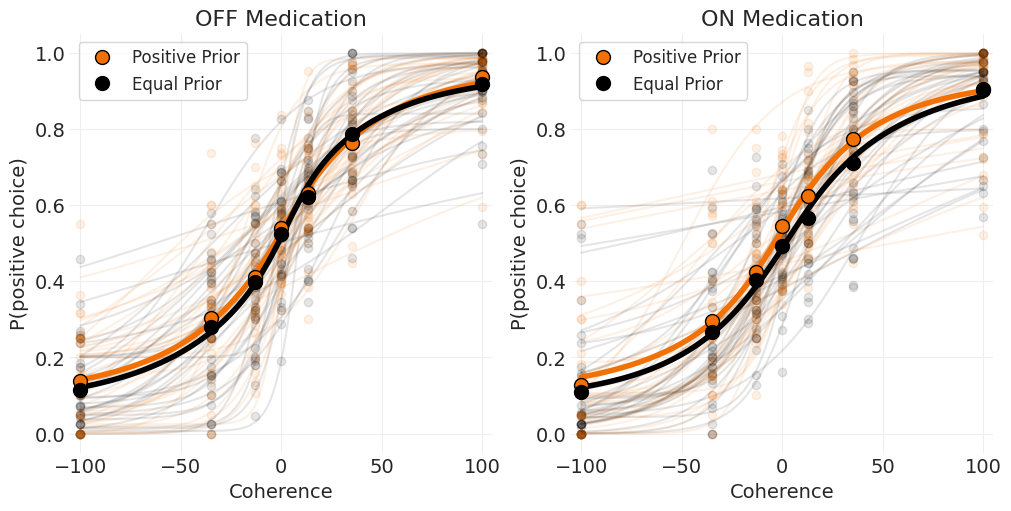

In [137]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
subject_alpha = 0.1
positive_color = 'C5'
equal_color = 'black'

sub_off_pos_coh, sub_off_pos_psych, sub_off_pos_model, sub_off_pos_x_hat, sub_off_pos_y_hat = [], [], [], [], []
sub_off_eq_coh, sub_off_eq_psych, sub_off_eq_model, sub_off_eq_x_hat, sub_off_eq_y_hat = [], [], [], [], []
sub_on_pos_coh, sub_on_pos_psych, sub_on_pos_model, sub_on_pos_x_hat, sub_on_pos_y_hat = [], [], [], [], []
sub_on_eq_coh, sub_on_eq_psych, sub_on_eq_model, sub_on_eq_x_hat, sub_on_eq_y_hat = [], [], [], [], []


for i, subject in enumerate(valid_subjects):
    subject_data = valid_data[valid_data['subject_id'] == subject]
    subject_data = subject_data.sort_values('medication')

    subject_metadata = session_metadata.loc[session_metadata['subject_id'] == subject]
    for idx, med in enumerate(subject_data['medication'].unique()):
        med_data = subject_data[subject_data['medication'] == med]
        pos_coh, pos_psych, pos_model, pos_x_hat, pos_y_hat = pmf_utils.get_psychometric_data(med_data[med_data['color'] == 1], model_type=psych_model_type)
        eq_coh, eq_psych, eq_model, eq_x_hat, eq_y_hat = pmf_utils.get_psychometric_data(med_data[med_data['color'] == 0], model_type=psych_model_type)
        if med == 'off':
            ax_idx = 0
            sub_off_pos_coh.append(pos_coh)
            sub_off_pos_psych.append(pos_psych)
            sub_off_pos_model.append(pos_model)
            sub_off_pos_x_hat.append(pos_x_hat)
            sub_off_pos_y_hat.append(pos_y_hat)
            sub_off_eq_coh.append(eq_coh)
            sub_off_eq_psych.append(eq_psych)
            sub_off_eq_model.append(eq_model)
            sub_off_eq_x_hat.append(eq_x_hat)
            sub_off_eq_y_hat.append(eq_y_hat)
        elif med == 'on':
            ax_idx = 1
            sub_on_pos_coh.append(pos_coh)
            sub_on_pos_psych.append(pos_psych)
            sub_on_pos_model.append(pos_model)
            sub_on_pos_x_hat.append(pos_x_hat)
            sub_on_pos_y_hat.append(pos_y_hat)
            sub_on_eq_coh.append(eq_coh)
            sub_on_eq_psych.append(eq_psych)
            sub_on_eq_model.append(eq_model)
            sub_on_eq_x_hat.append(eq_x_hat)
            sub_on_eq_y_hat.append(eq_y_hat)

        ax[ax_idx].plot(pos_coh, pos_psych, color=positive_color, marker='o', linestyle='',alpha=subject_alpha)
        ax[ax_idx].plot(pos_x_hat, pos_y_hat, color=positive_color, linestyle='-',  alpha=subject_alpha)
        ax[ax_idx].plot(eq_coh, eq_psych, color=equal_color, marker='o', linestyle='', alpha=subject_alpha)
        ax[ax_idx].plot(eq_x_hat, eq_y_hat, color=equal_color, linestyle='-',  alpha=subject_alpha)

ax[0].plot(np.mean(sub_off_pos_x_hat, axis=0), np.mean(sub_off_pos_y_hat, axis=0), color=positive_color, linestyle='-',  lw=4, alpha=1)
ax[0].plot(np.mean(sub_off_eq_x_hat, axis=0), np.mean(sub_off_eq_y_hat, axis=0), color=equal_color, linestyle='-',  lw=4, alpha=1)
ax[0].plot(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), color=positive_color, marker='o', linestyle='', ms=10, mec='k', label='Positive Prior', alpha=1)
ax[0].plot(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), color=equal_color, marker='o', linestyle='', ms=10, mec='k', label='Equal Prior', alpha=1)

ax[1].plot(np.mean(sub_on_pos_x_hat, axis=0), np.mean(sub_on_pos_y_hat, axis=0), color=positive_color, linestyle='-',  lw=4, alpha=1)
ax[1].plot(np.mean(sub_on_eq_x_hat, axis=0), np.mean(sub_on_eq_y_hat, axis=0), color=equal_color, linestyle='-',  lw=4, alpha=1)
ax[1].plot(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), color=positive_color, marker='o', linestyle='', ms=10, mec='k', label='Positive Prior', alpha=1)
ax[1].plot(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), color=equal_color, marker='o', linestyle='', ms=10, mec='k', label='Equal Prior', alpha=1)

ax[0].set_title(f"OFF Medication", fontsize=16)
ax[0].set_xlabel('Coherence', fontsize=14)
ax[0].set_ylabel('P(positive choice)', fontsize=14)
ax[0].set_xlim(-105, 105)
ax[0].set_ylim(-0.05, 1.05)
ax[0].legend()
ax[1].set_title(f"ON Medication", fontsize=16)
ax[1].set_xlabel('Coherence', fontsize=14)
ax[1].set_ylabel('P(positive choice)', fontsize=14)
ax[1].set_xlim(-105, 105)
ax[1].set_ylim(-0.05, 1.05)
ax[1].legend()



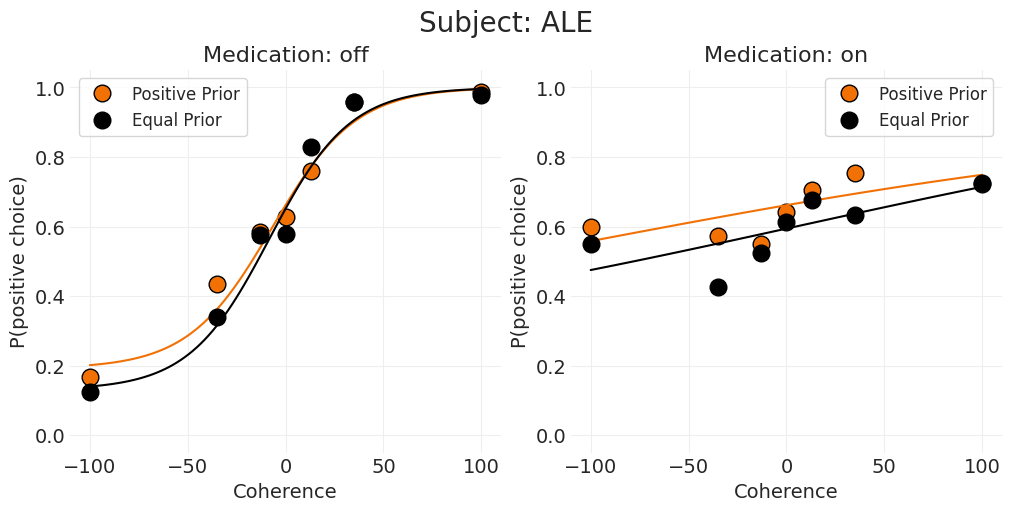

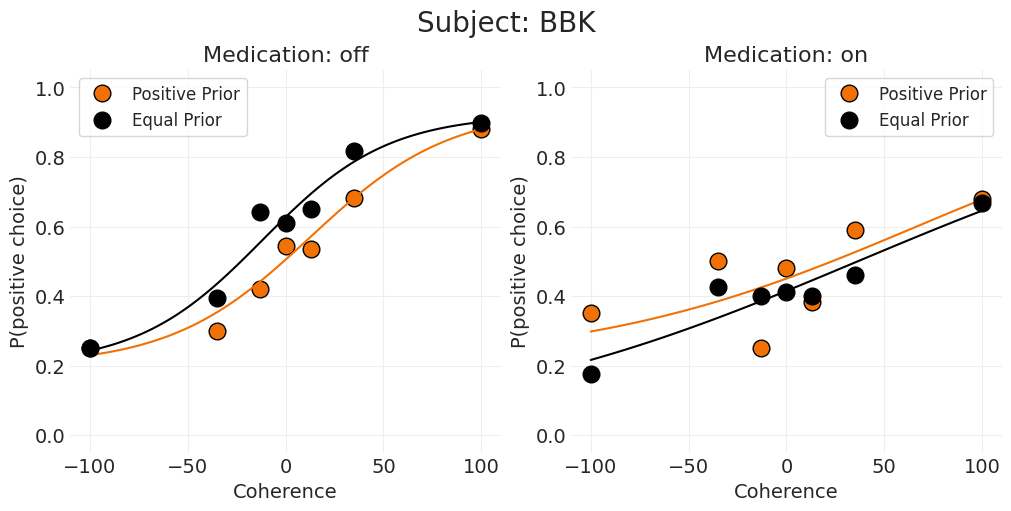

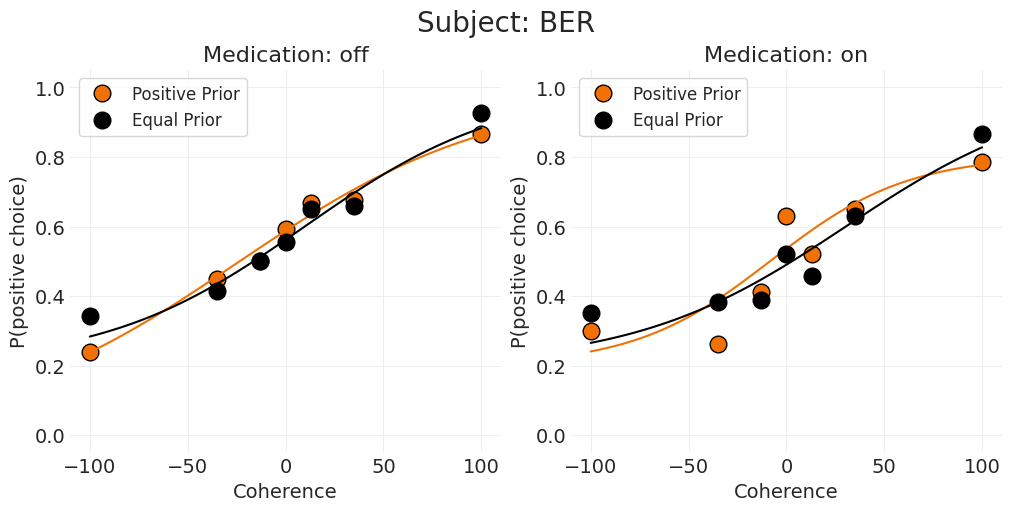

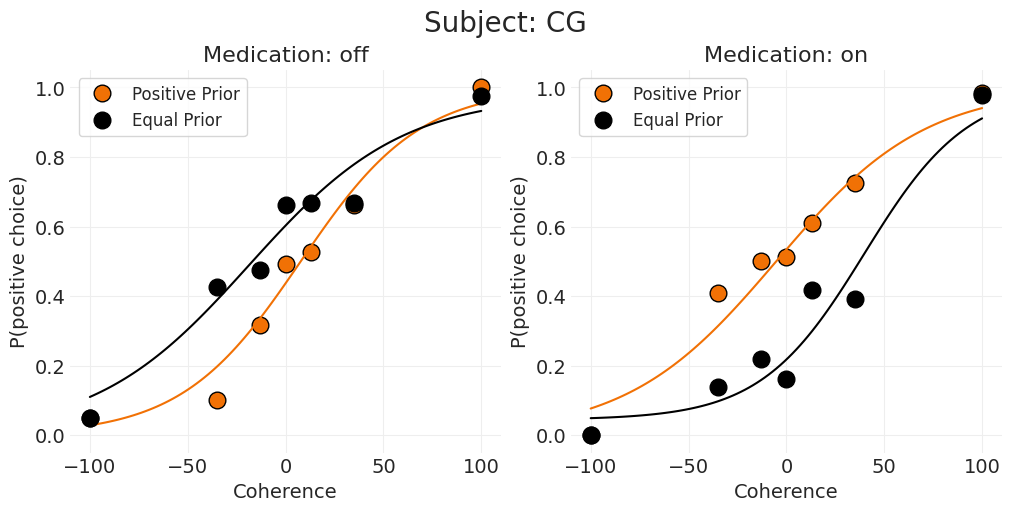

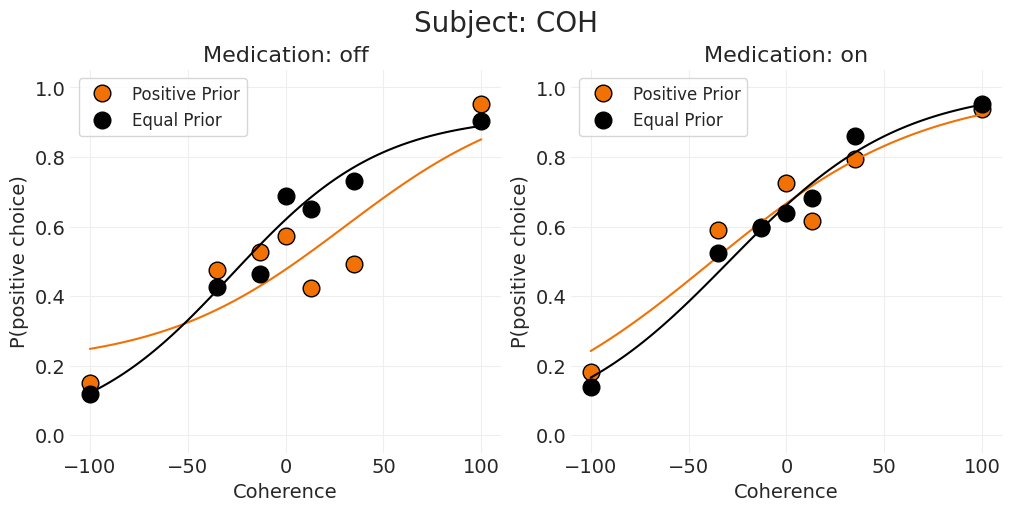

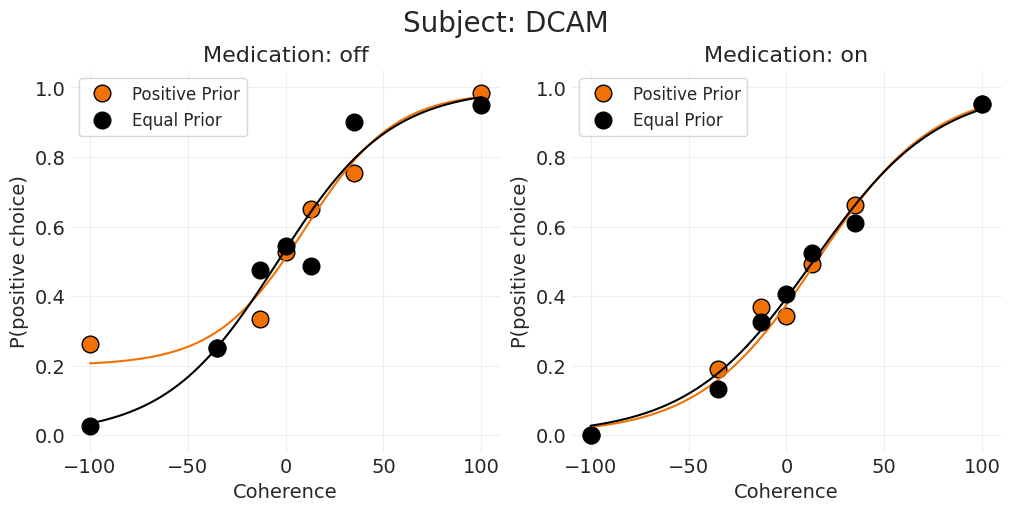

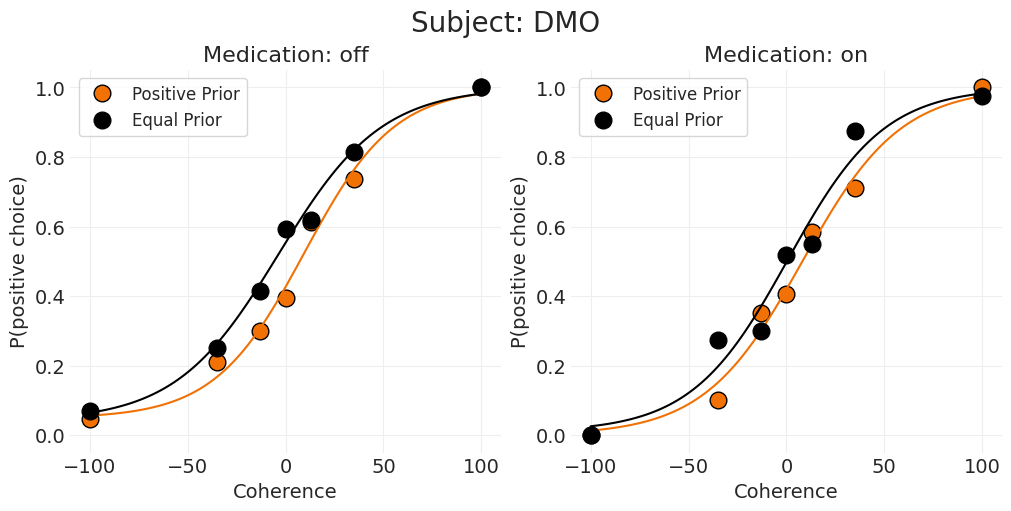

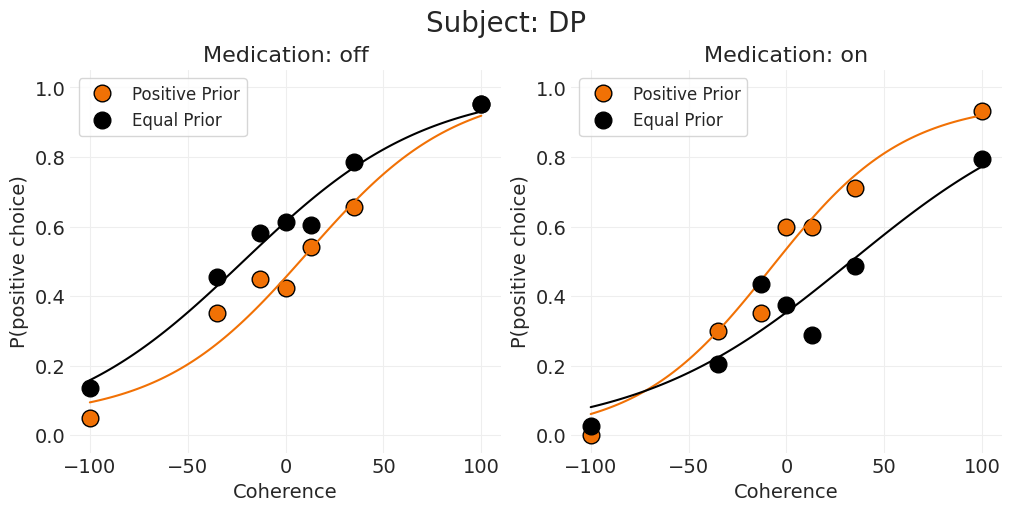

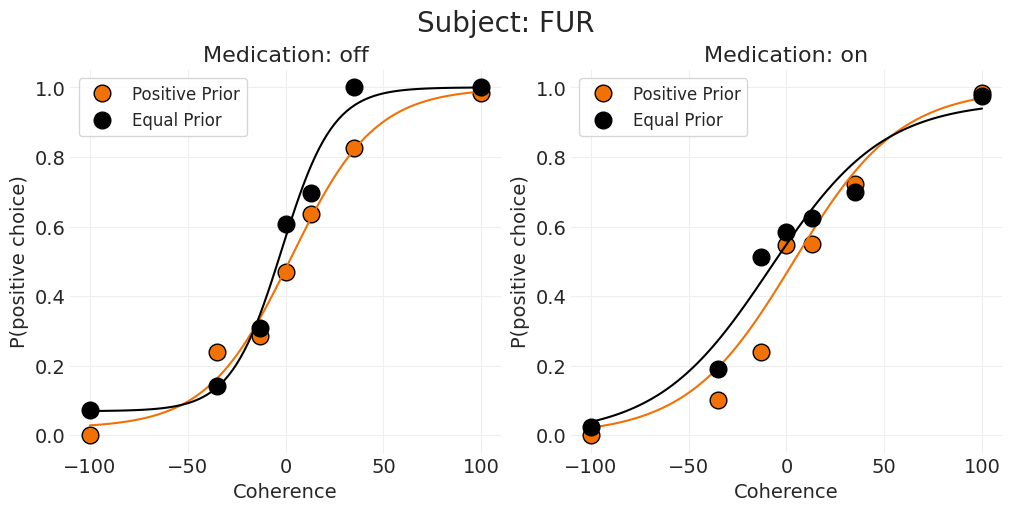

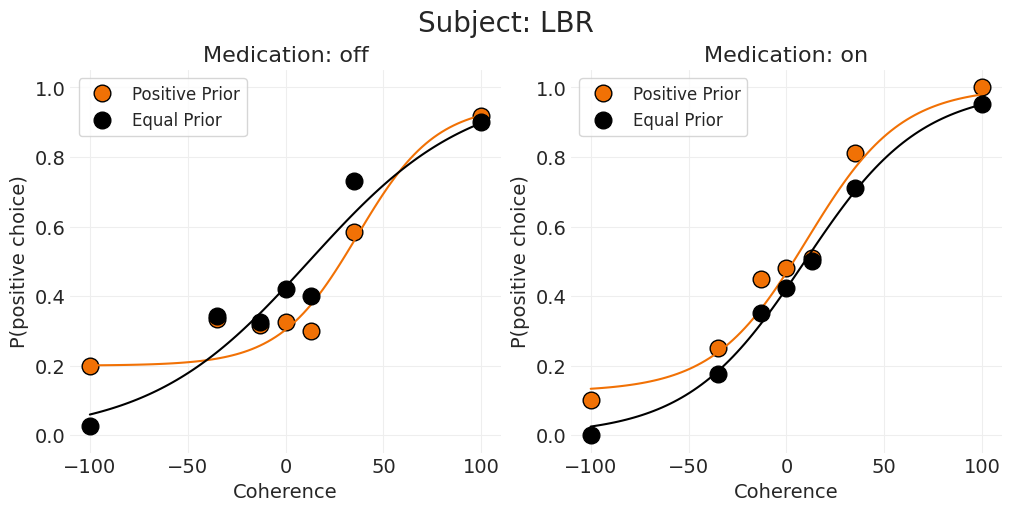

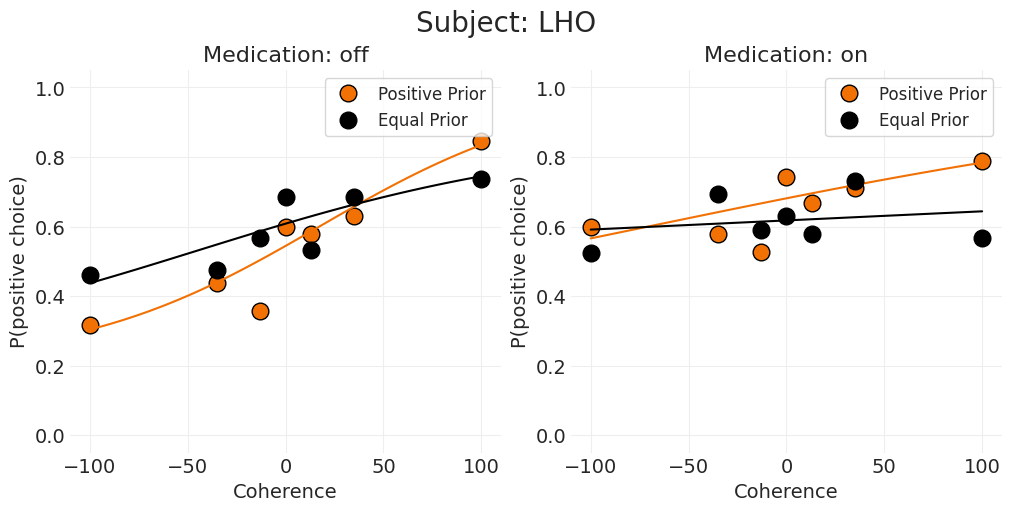

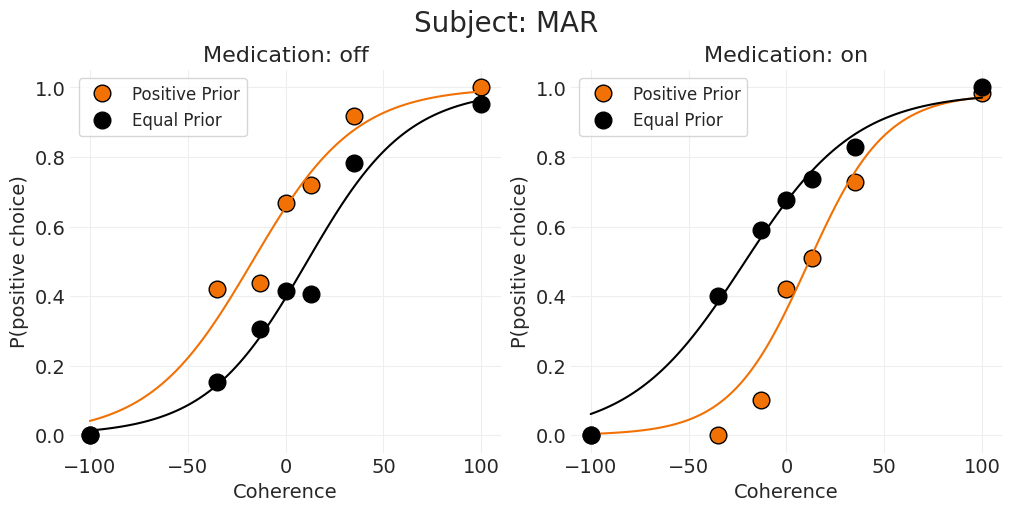

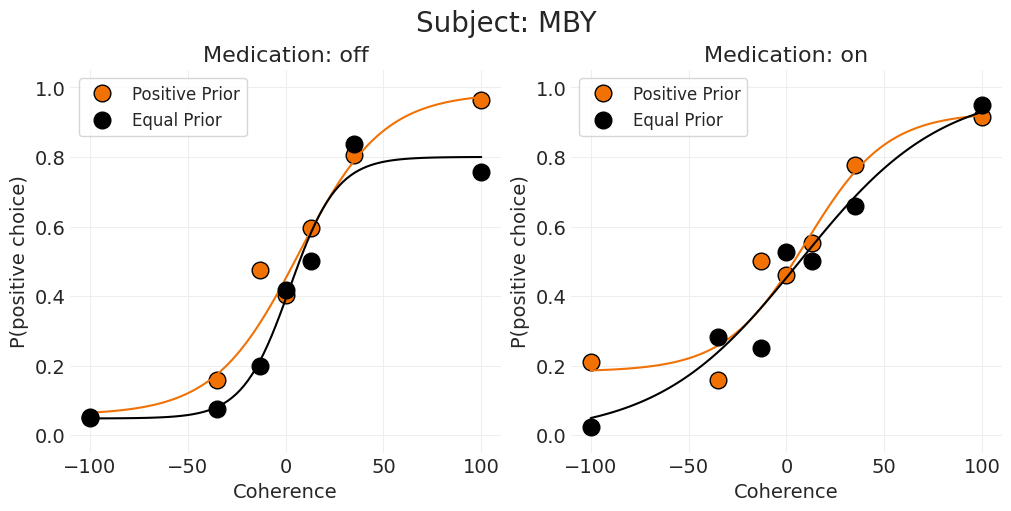

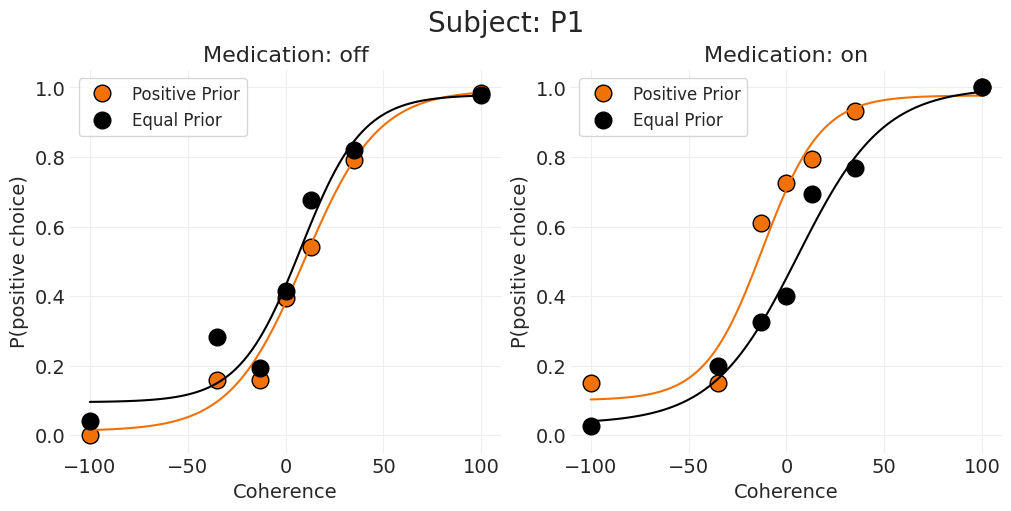

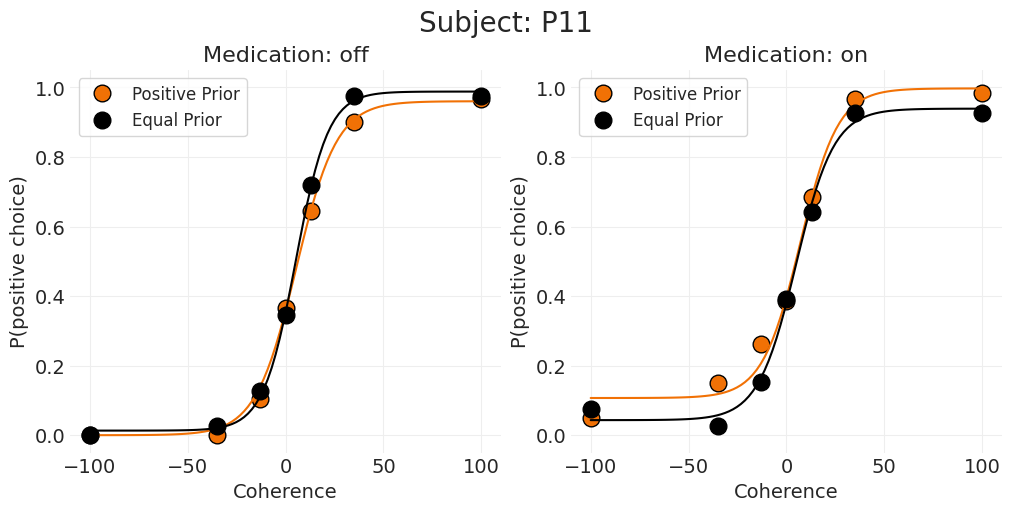

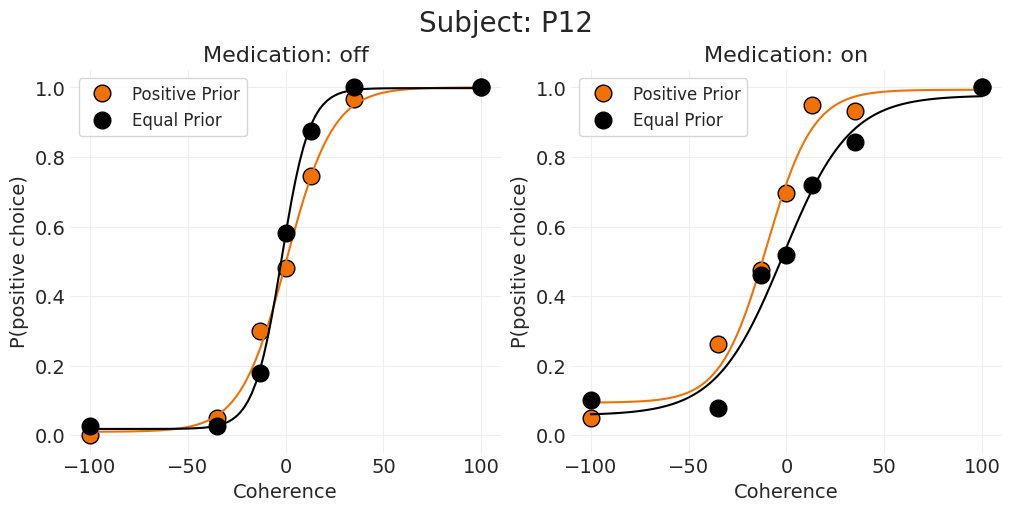

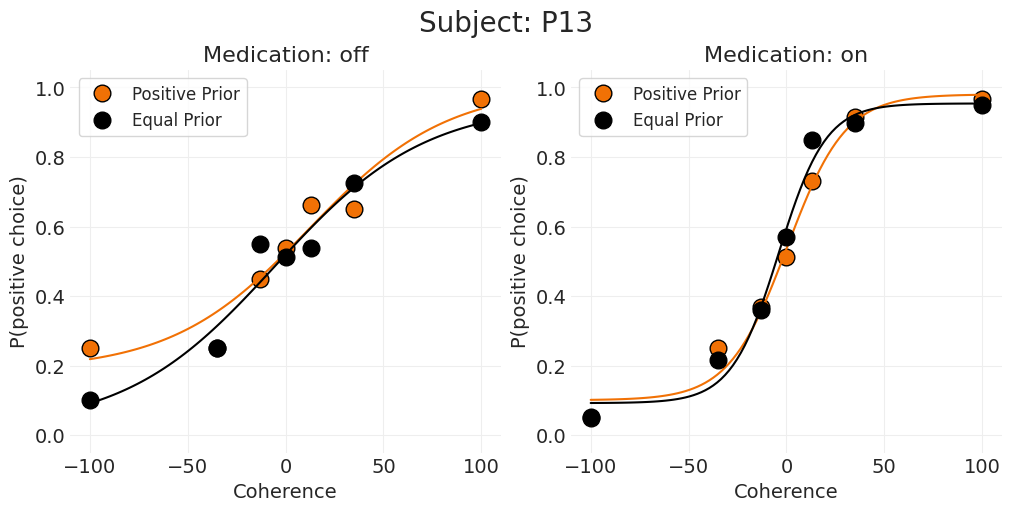

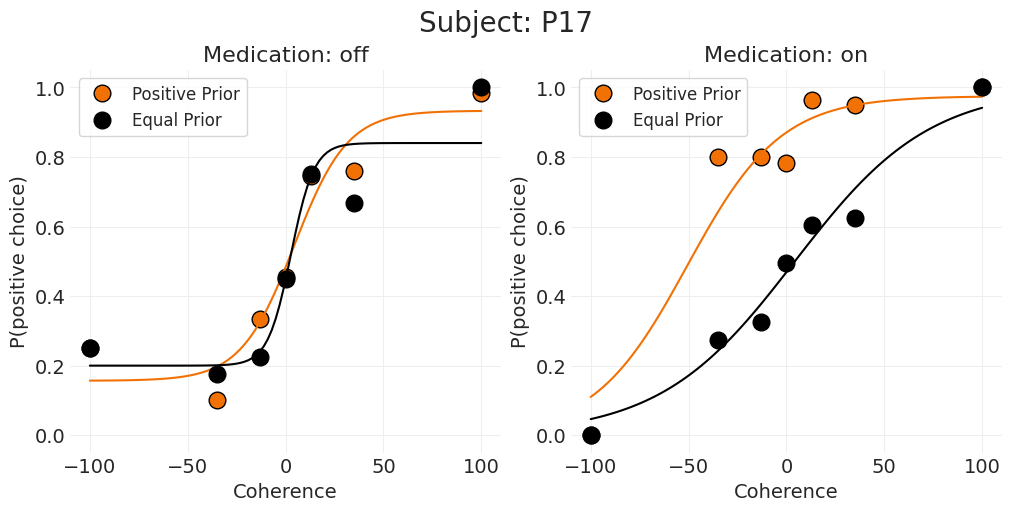

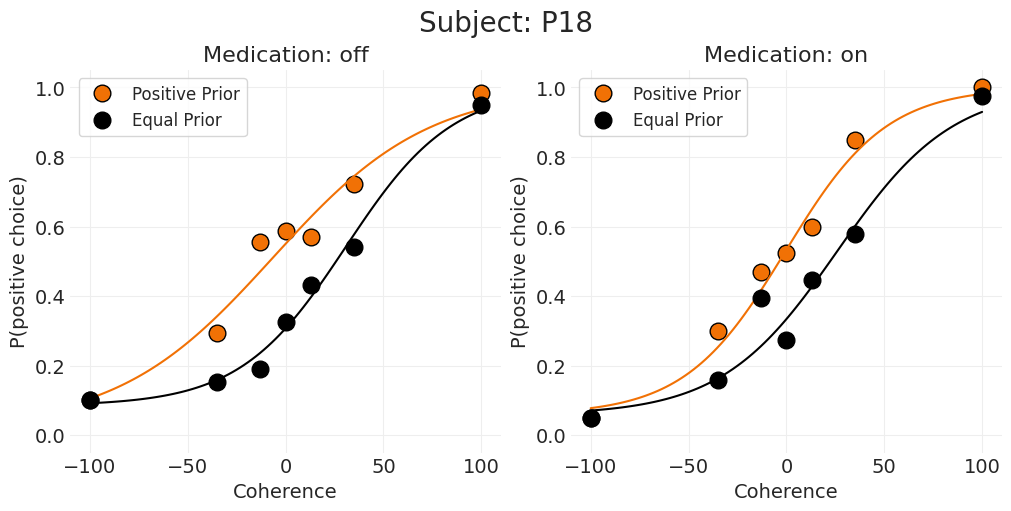

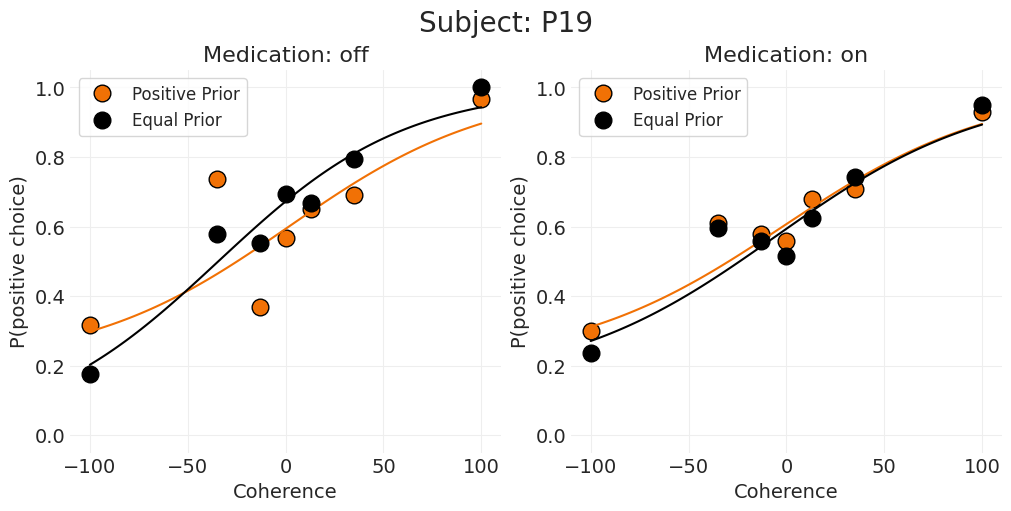

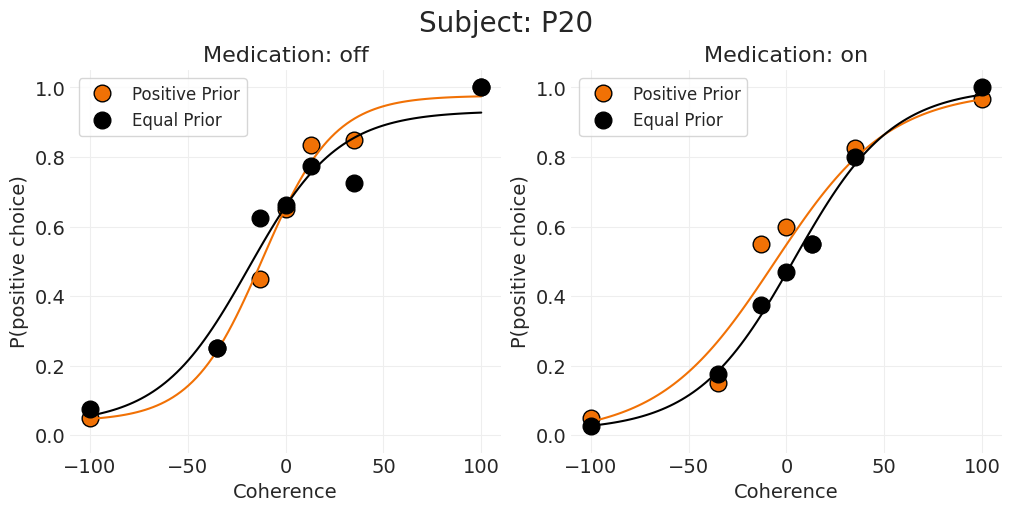

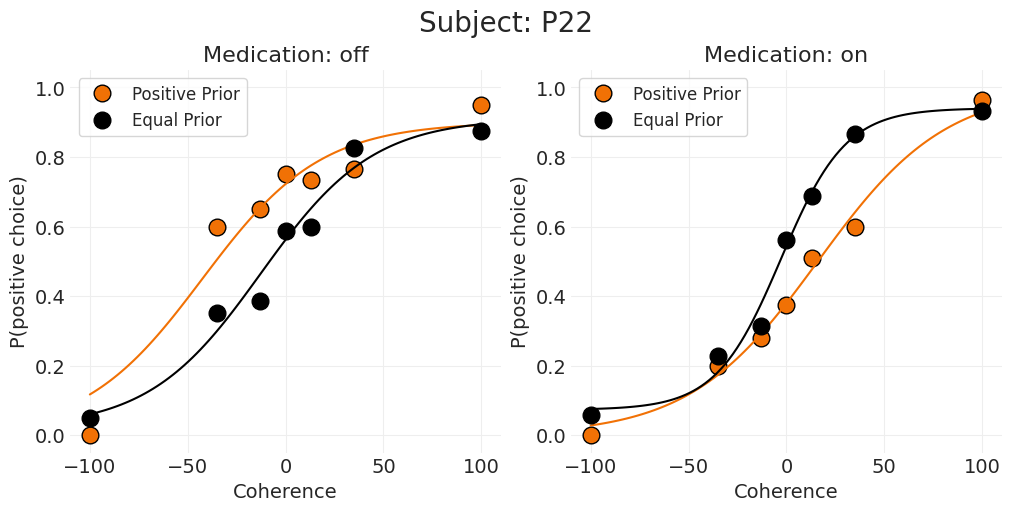

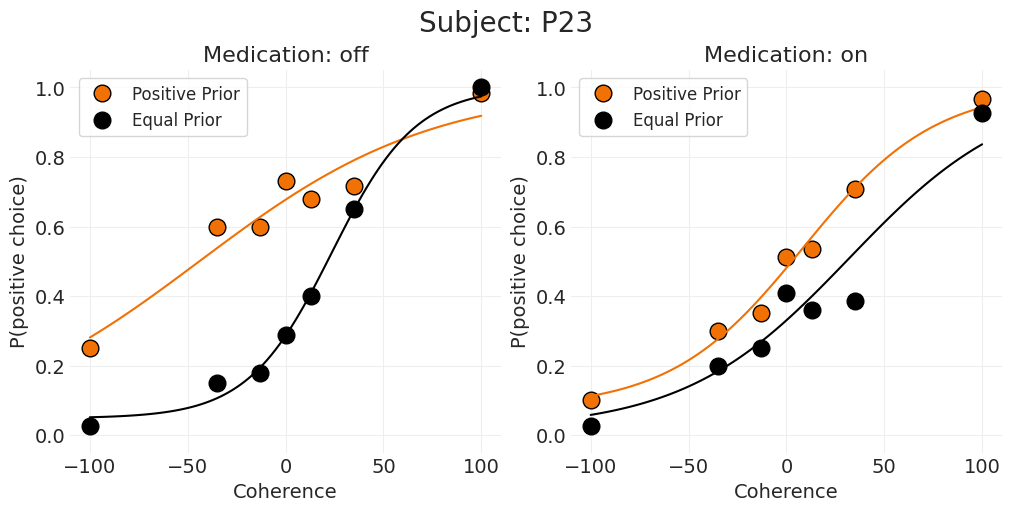

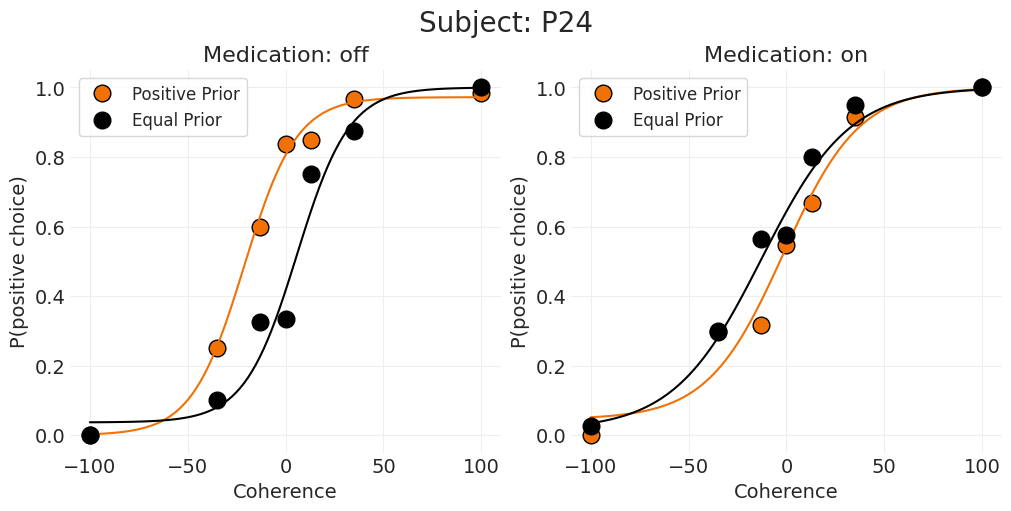

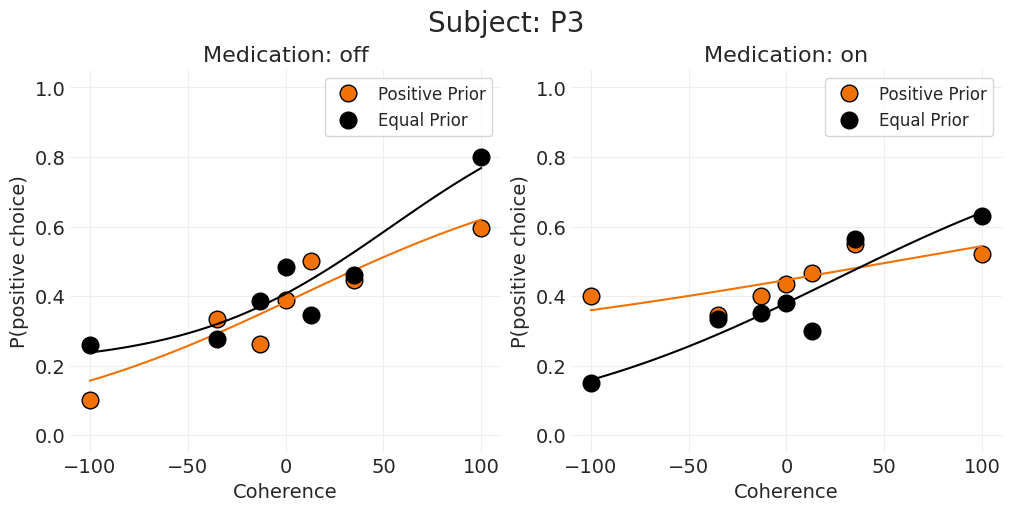

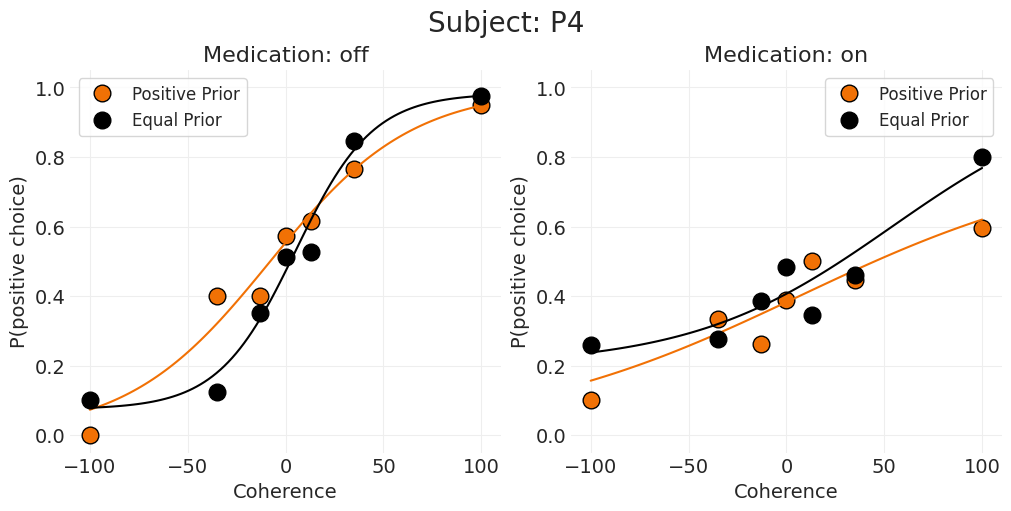

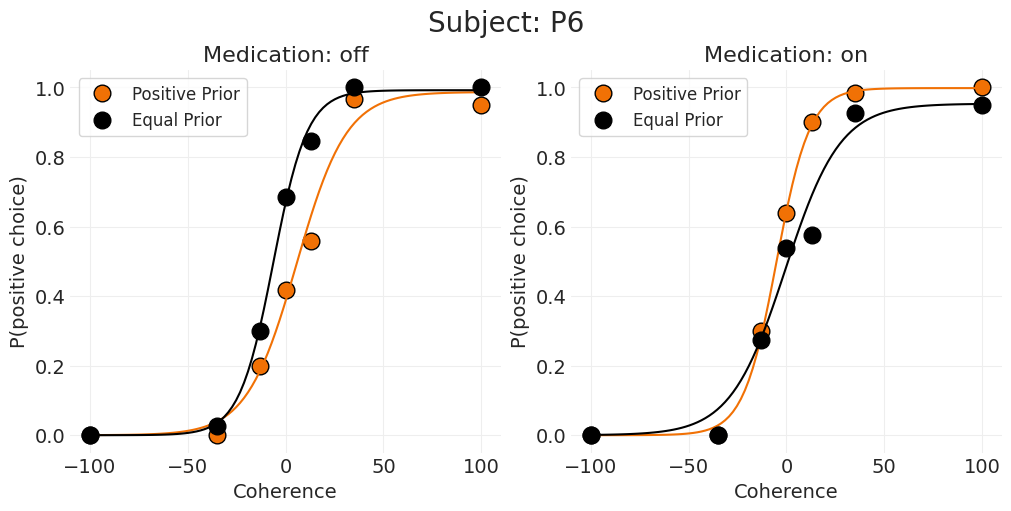

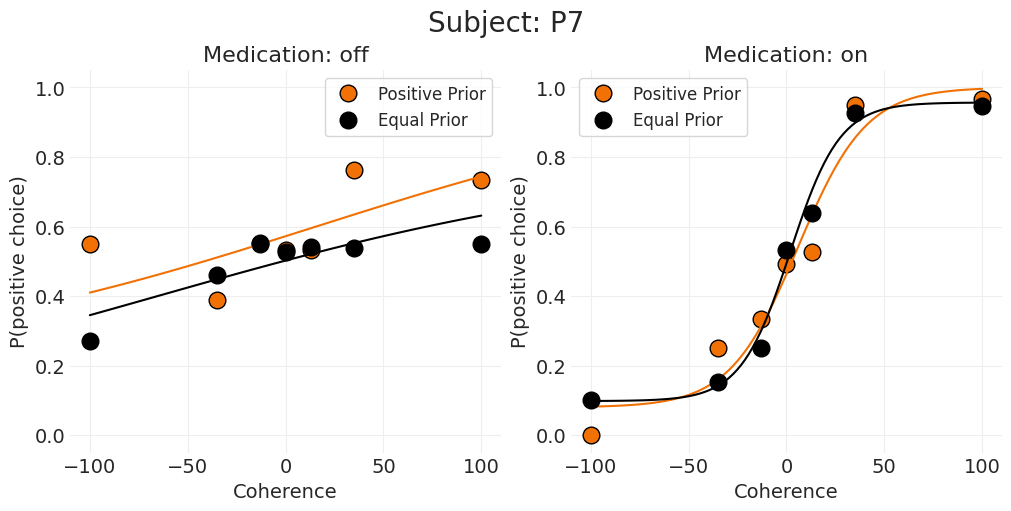

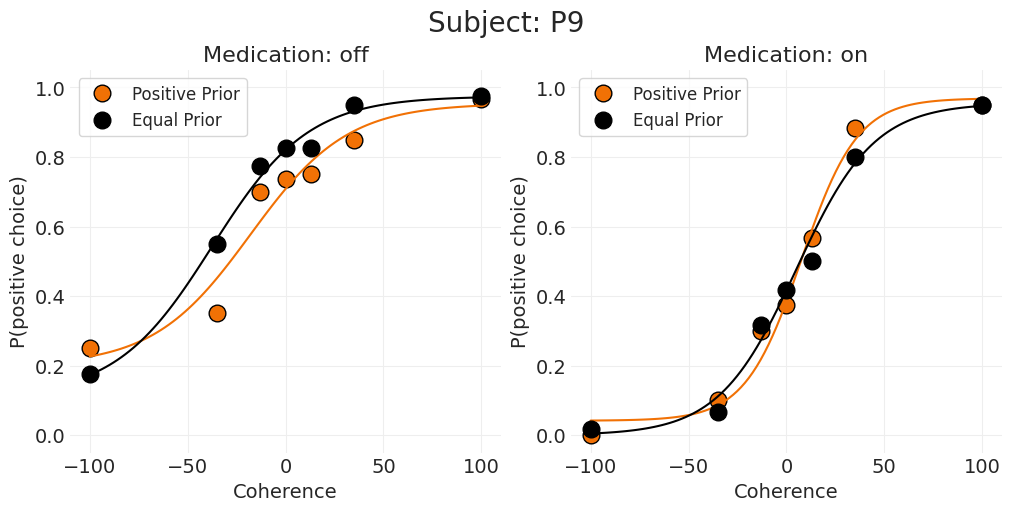

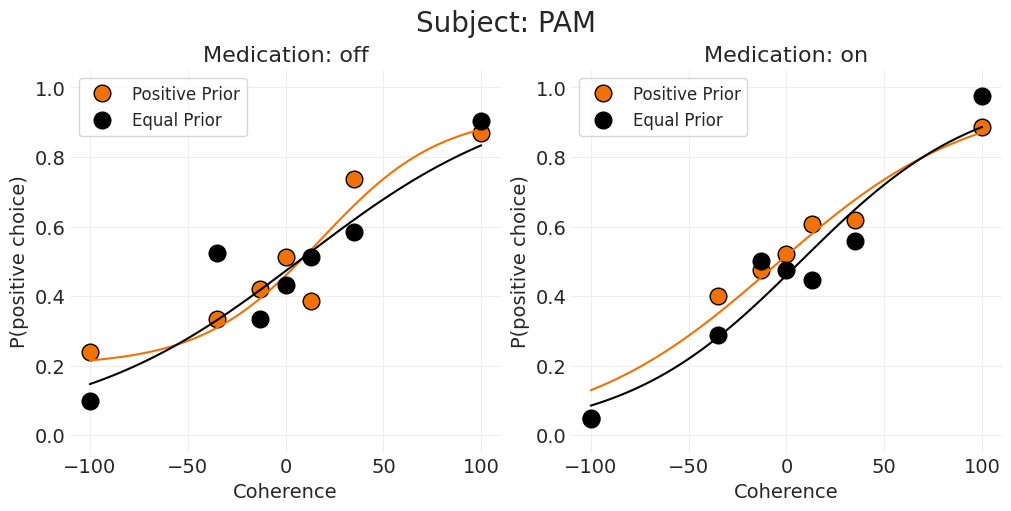

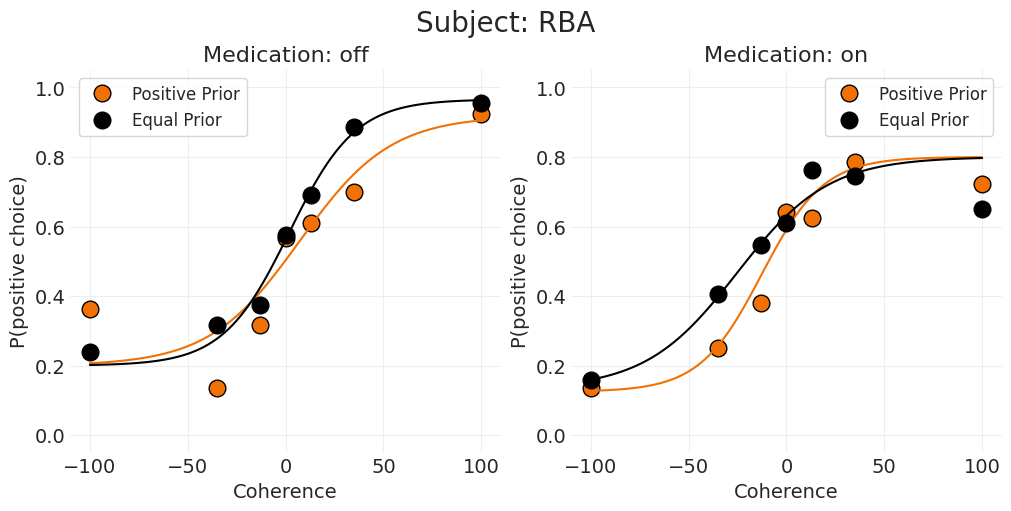

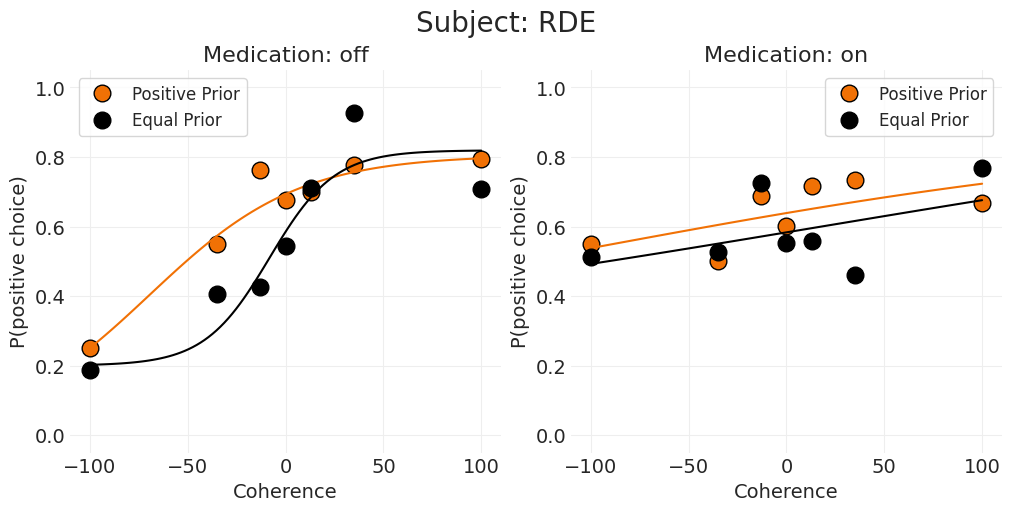

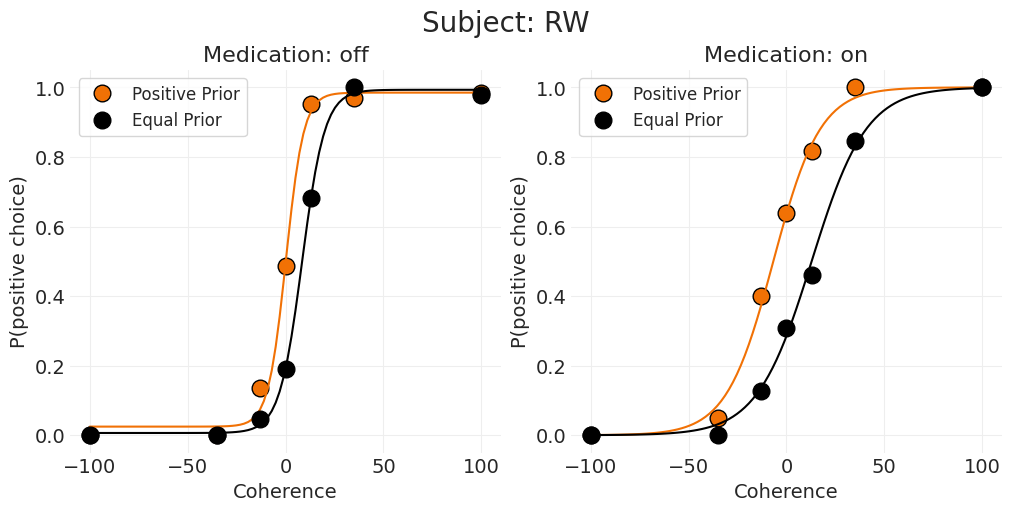

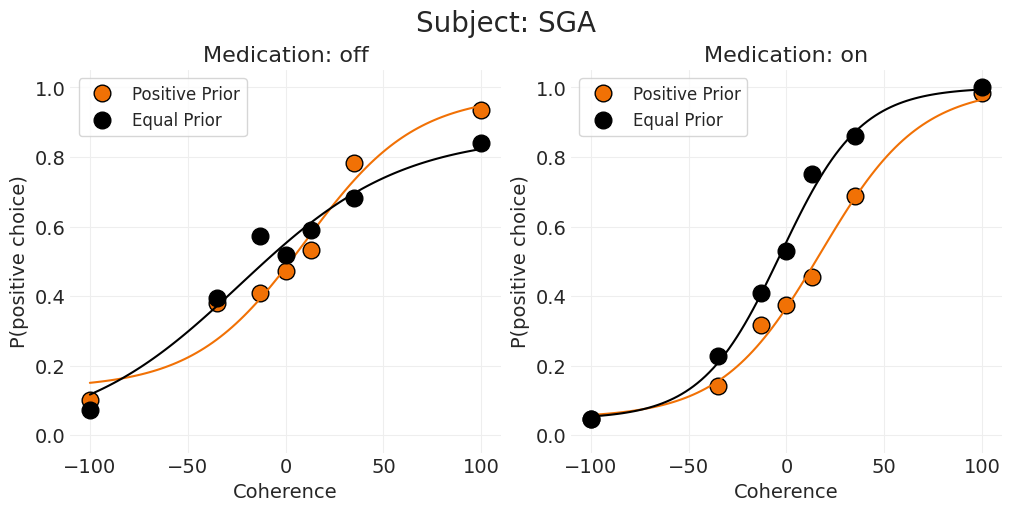

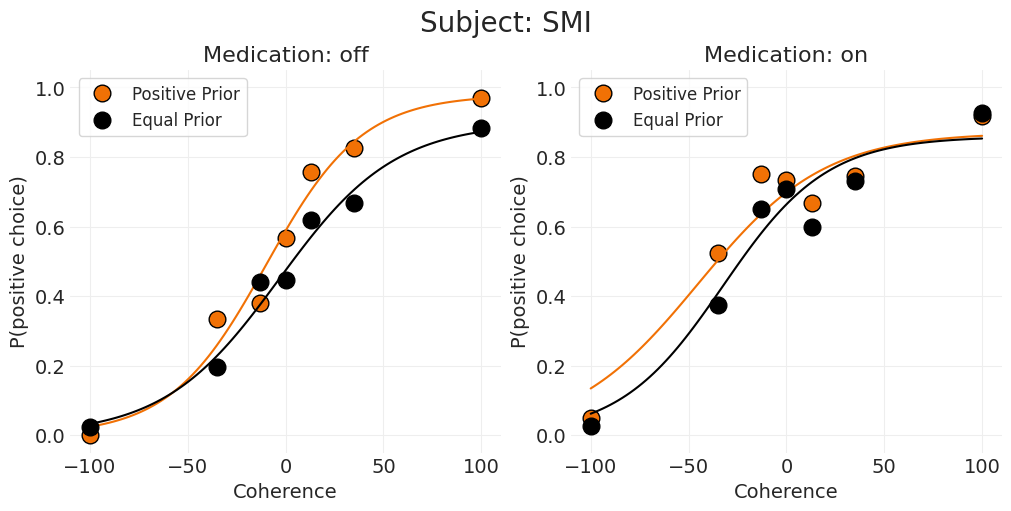

In [138]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors

subject_alpha = 0.08
positive_color = 'C5'
equal_color = 'black'
error_plot_style = {'elinewidth': 2, 'capsize': 10, 'capthick': 2}

ax[idx].plot(pos_coh, pos_psych, color=positive_color, ls='', alpha=subject_alpha)
ax[idx].plot(pos_x_hat, pos_y_hat, color=positive_color, ls='-', alpha=subject_alpha)
ax[idx].plot(eq_coh, eq_psych, color=equal_color, ls='', alpha=subject_alpha)
ax[idx].plot(eq_x_hat, eq_y_hat, color=equal_color, ls='-', alpha=subject_alpha)

for i, subject in enumerate(valid_subjects):

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    subject_data = valid_data[valid_data['subject_id'] == subject]
    subject_data = subject_data.sort_values('medication')

    for idx, med in enumerate(subject_data['medication'].unique()):
        med_data = subject_data[subject_data['medication'] == med]
        coh, psych, model, x_hat, y_hat = pmf_utils.get_psychometric_data(med_data[med_data['color'] == 1], model_type='logit_4')
        ax[idx].plot(coh, psych, marker='o', ms=12, mec='k', color=positive_color, ls='', label='Positive Prior')
        ax[idx].plot(x_hat, y_hat, color=positive_color, ls='-')
        coh, psych, model, x_hat, y_hat = pmf_utils.get_psychometric_data(med_data[med_data['color'] == 0], model_type='logit_4')
        ax[idx].plot(coh, psych, marker='o', ms=12, mec='k', color=equal_color, ls='', label='Equal Prior')
        ax[idx].plot(x_hat, y_hat, color=equal_color, ls='-')
        ax[idx].set_title(f"Medication: {med}", fontsize=16)
        ax[idx].set_xlabel('Coherence', fontsize=14)
        ax[idx].set_ylabel('P(positive choice)', fontsize=14)
        ax[idx].legend()
        ax[idx].set_ylim(-0.05, 1.05)
        ax[idx].tick_params(axis='both', labelsize=14)
        ax[idx].spines['top'].set_visible(False)
        ax[idx].spines['right'].set_visible(False)

    fig.suptitle(f"Subject: {subject}", fontsize=20)

### Save data and data results (metadata)

In [139]:
session_metadata.keys()

Index(['subject_id', 'treatment', 'off_med_first', 'is_tremor_dominant',
       'MoCA', 'sMMSE', 'BDI', 'BAI', 'UPDRS', '210_Tremor', '301_Speech',
       '302_Facial_Expression', '303a_Rigidity_Neck', '303b_Rigidity_RUE',
       '303c_Rigidity_LUE', '303d_Rigidity_RLE', '303e_Rigidity_LLE',
       '304a_Finger_Tapping_RUE', '304b_Finger_Tapping_LUE',
       '305a_Hand_Movements_RUE', '305b_Hand_Movements_LUE',
       '306a_Pronation_Supination_Movements_RUE',
       '306b_Pronation_Supination_Movements_LUE', '307a_Toe_Tapping_RLE',
       '307b_Toe_Tapping_LLE', '308a_Leg_Agility_RLE', '308b_Leg_Agility_LLE',
       '309_Arising_from_Chair', '310_Gait', '311_Freezing_of_Gait',
       '312_Postural_Stability', '313_Posture',
       '314_Global_Spontaneity_of_Movement', '315a_Postural_Tremor_RUE',
       '315b_Postural_Tremor_LUE', '316a_Kinetic_Tremor_RUE',
       '316b_Kinetic_Tremor_LUE', '317a_Rest_Tremor_Amplitude_RUE',
       '317b_Rest_Tremor_Amplitude_LUE', '317c_Rest_Tremor_Amp

In [140]:
session_metadata['session_id'] = session_metadata[['subject_id', 'treatment']].apply(lambda x: '_'.join(x.astype(str).str.upper()), axis=1)
valid_data['session_id'] = valid_data[['subject_id', 'medication']].apply(lambda x: '_'.join(x.astype(str).str.upper()), axis=1)
aggregate_data['session_id'] = aggregate_data[['subject_id', 'medication']].apply(lambda x: '_'.join(x.astype(str).str.upper()), axis=1)

In [141]:
session_metadata = session_metadata[session_metadata['subject_id'].isin(valid_subjects)]
valid_data = valid_data[valid_data['subject_id'].isin(valid_subjects)]
aggregate_data = aggregate_data[aggregate_data['subject_id'].isin(valid_subjects)]

session_metadata.to_csv(Path(processed_dir, "processed_metadata_accu_60.csv"), index=False)
aggregate_data.to_csv(Path(processed_dir, "processed_data_accu_60_all.csv"), index=False)
valid_data.to_csv(Path(processed_dir, "processed_data_accu_60_filtered.csv"), index=False)